In [1]:
%pip install tensorflow==2.18.0 tensorflow-hub==0.16.1

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/390.3 MB ? eta -:--:--
   ---------------------------------------- 1.0/390.3 MB 68.9 MB/s eta 0:00:06
   ---------------------------------------- 1.0/390.3 MB 68.9 MB/s eta 0:00:06
   ---------------------------------------- 2.1/390.3 MB 19.1 MB/s eta 0:00:21
   ---------------------------------------- 2.5/390.3 MB 14.4 MB/s eta 0:00:27
   ---------------------------------------- 3.1/390.3 MB 16.8 MB/s eta 0:00:24
   ---------------------------------------- 3.7/390.3 MB 14.0 MB/s eta 0:00:28
   ---------------------------------------- 4.2/390.3 MB 14.1 MB/s eta 0:00:28
    --------------------------------------- 5.2/390.3 MB 14.6 MB/s eta 0:00:27
    --------------------------------------- 5.2/390.3 MB 14.6 MB/s eta 0:00:27
    --------------------------------------- 6.3/390.3 MB 14.4 MB/s eta 0:

In [1]:
# 1. Setup
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# 2. Paths
DATA_DIR = "data/PlantVillage"  

In [3]:
# 3. Parameters
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 123

In [4]:
# 4. Load the Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 41276 files belonging to 16 classes.
Using 33021 files for training.
Found 41276 files belonging to 16 classes.
Using 8255 files for validation.


In [5]:
# 5. Class names
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Detected classes: {class_names}")

Detected classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'PlantVillage', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [6]:
# 6. Optimize input pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [7]:
# 7. Data normalization
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
base_model.trainable = False  # Freeze base

inputs = tf.keras.Input(shape=(224, 224, 3))
x = normalization_layer(inputs)
x = base_model(x, training=False)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
# 10. Train Model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 713s 687ms/step - accuracy: 0.4788 - loss: 1.3035 - val_accuracy: 0.4841 - val_loss: 0.9589
Epoch 2/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 682s 661ms/step - accuracy: 0.4925 - loss: 0.9730 - val_accuracy: 0.4548 - val_loss: 0.9278
Epoch 3/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 696s 674ms/step - accuracy: 0.4936 - loss: 0.9236 - val_accuracy: 0.4705 - val_loss: 0.9244
Epoch 4/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 671s 650ms/step - accuracy: 0.4980 - loss: 0.8951 - val_accuracy: 0.4676 - val_loss: 0.9227
Epoch 5/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 660s 640ms/step - accuracy: 0.5031 - loss: 0.8750 - val_accuracy: 0.4509 - val_loss: 0.9236
Epoch 6/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 648s 628ms/step - accuracy: 0.5060 - loss: 0.8552 - val_accuracy: 0.4296 - val_loss: 0.9030
Epoch 7/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 655s 635ms/step - accuracy: 0.5051 - loss: 0.8419 - val_accuracy: 0.4463 - val_loss: 0.9237
Epoch 8/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 691s 670ms/step - ac

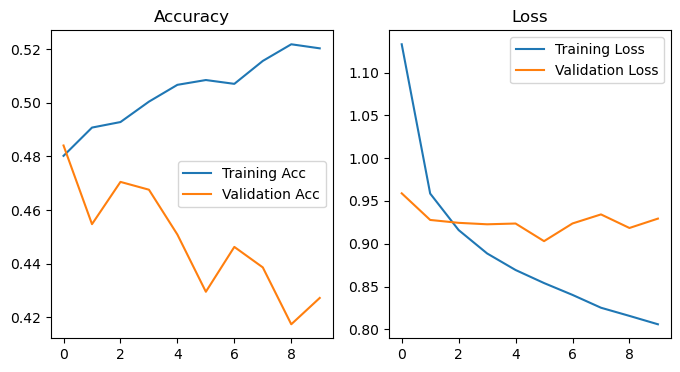

In [14]:
# 11. Plot Accuracy & Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Acc')
plt.plot(epochs_range, val_acc, label='Validation Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [16]:
# 12. Save Model
model.save("model/plant_disease_classifier.h5")